In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [19]:
#getting image and rescale
doffs_old = 174.186
baseline_old = 177.288
width_old = 2988
height_old = 2008
n_disp_old = 180
SF = 0.3

img1 = cv2.imread("left.png")
img2 = cv2.imread("right.png")

height = int(img1.shape[0]*SF)
width = int(img1.shape[1]*SF)
dsize = (width,height)


img1_scaled = cv2.resize(img1,dsize)
img2_scaled = cv2.resize(img2,dsize)
cv2.imwrite("reference.png",img1_scaled)

img1 = cv2.GaussianBlur(img1_scaled,(3,3),0)
img2 = cv2.GaussianBlur(img2_scaled,(3,3),0)

img1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

out1 = cv2.Laplacian(img1_gray,cv2.CV_16S,ksize = 3)
out2 = cv2.Laplacian(img2_gray,cv2.CV_16S,ksize = 3)

imageL = cv2.convertScaleAbs(out1)
imageR = cv2.convertScaleAbs(out2)


doffs = doffs_old * SF
width = width_old * SF
height = height_old * SF
baseline = baseline_old * SF
n_disp = int(n_disp_old * SF)



Done


In [14]:
#getting pixel values 
rows,cols = imageL.shape

pix_1 = np.zeros((rows,cols))
pix_2 = np.zeros((rows,cols))

for i in range (rows):
    for j in range (cols):
        pix_1[i][j] = imageL[i][j]
        pix_2[i][j] = imageR[i][j]

        
p

(602, 896)


In [15]:
def rolling_window(array, window_size):
    itemsize = array.itemsize
    # broadcast window_size so it will still work with a scalar:
    window_size = np.broadcast_to(window_size,[2,])
    shape = (array.shape[0] - window_size[0] + 1,
             array.shape[1] - window_size[1] + 1,
             window_size[0], window_size[1])
    # the following would also work:
    # shape = (*np.array(array.shape) - window_size + 1, *window_size)
    strides = (array.shape[1] * itemsize, itemsize,
               array.shape[1] * itemsize, itemsize)
    return np.lib.stride_tricks.as_strided(array, shape=shape, strides=strides)

win_1 = rolling_window(pix_1,[7,7])
win_2 = rolling_window(pix_2,[7,7])




(596, 890, 7, 7)
(596, 890, 7, 7)


In [15]:
disp = np.zeros((win_1.shape[0],win_1.shape[1]))
r = np.zeros((win_1.shape[0],win_1.shape[1]))
r_list = np.zeros((1,win_2.shape[1]))
max_indx = 0

for i in range (win_1.shape[0]):
    for q in range (win_1.shape[1]):
        Term1 = win_1[i][q] - np.mean(win_1[i][q])
        Term3 = np.sum(np.square(win_1[i][q] - np.mean(win_1[i][q])))
        if ((q+n_disp) >= win_1.shape[1]):
            boundary = win_1.shape[1]
        else:
            boundary = q + n_disp
        max_indx = q
        for z in range (q,boundary):
            Term2 = win_2[i][z] - np.mean(win_2[i][z])
            Term4 = np.sum(np.square(win_2[i][z] - np.mean(win_2[i][z])))
            Numerator = np.sum(Term1*Term2)
            coeff = Numerator/((Term3*Term4)**(0.5))
            r_list[0][z] = coeff 
            if (np.amax(r_list) == coeff):
                max_indx = z
        r[i][q] = np.amax(r_list)
        disp[i][q] = (max_indx - q)
        
f = open("Disparity.txt","w+")
np.savetxt("Disparity.txt",disp,delimiter=',')


       


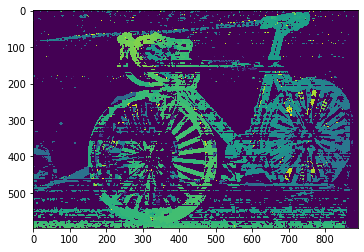

In [32]:
disp = np.loadtxt("Disparity.txt",dtype = float,delimiter=",")
plt.imshow(disp)

In [35]:
# depth (z) = focal length (f) * baseline (b) / disparity (d)


# have to reload the picture to obtain the coloured version



im = np.asarray(Image.open("reference.png"))


[205 211 196]


In [36]:
focal = 5299.313 * SF
z = np.zeros((win_1.shape[0],win_1.shape[1]))
x = np.zeros((win_1.shape[0],win_1.shape[1]))
y = np.zeros((win_1.shape[0],win_1.shape[1]))
#color = np.zeros((win_1.shape[0], win_1.shape[1],3))

point_cloud = np.zeros((win_1.shape[0],win_1.shape[1],6))

z = focal * baseline / (disp + doffs) 

for i in range (disp.shape[0]):
    for q in range (disp.shape[1]):
        x[i][q] = i
        y[i][q] = q

for i in range(point_cloud.shape[0]):
    for q in range (point_cloud.shape[1]):
        point_cloud[i][q][0] = x[i][q]
        point_cloud[i][q][1] = y[i][q]
        point_cloud[i][q][2] = z[i][q]
        point_cloud[i][q][3] = im[i][q][0]
        point_cloud[i][q][4] = im[i][q][1]
        point_cloud[i][q][5] = im[i][q][2]



f = open("Point Cloud.txt","w+")
for i in range (point_cloud.shape[0]):
    for q in range (point_cloud.shape[1]):
         f.write(str(point_cloud[i][q][0]) + "," + str(point_cloud[i][q][1]) + "," + str(point_cloud[i][q][2]) 
                 + "," + str(point_cloud[i][q][3]) + "," + str(point_cloud[i][q][4]) + "," + str(point_cloud[i][q][5]) + "\n")


f.close()


DONE
